In [1]:
import random 
from random import sample, seed, shuffle
import numpy as np
import pandas as pd
import os
import six
from rdkit import rdBase
from rdkit import RDLogger

# Suppress RDKit warnings
rdBase.DisableLog('rdApp.*')
RDLogger.DisableLog('rdApp.*')

#utility functions : prepare the data 
from model_fp_selection.lib.utils import prepare_df_morgan, prepare_df_rdkit, swap_identical_ligands, prepare_df_chemeleon
from model_fp_selection.lib.utils import drop_duplicates, average_duplicates

#utility functions : CV and results 
from model_fp_selection.lib.utils import obtain_metrics, plot_cv_results
from model_fp_selection.lib.utils import df_split, get_indices, get_indices_doi, get_indices_scaff
from model_fp_selection.lib.utils import generate_scaffold, scaffold_to_smiles
from model_fp_selection.lib.utils import ligands_permutation, cross_validation, prepare_train_set


from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, PredictionErrorDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import MinMaxScaler

#Encoding categorical Data
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Regressors
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Pipelines and other model constructions
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Visualization
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

#np.random.seed(42)
#seed(42)

#Specific to Scaffold Splitting
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import defaultdict
import pickle as pkl
import time
from tqdm import tqdm
import seaborn as sns

from itertools import *

In [3]:
metals = pd.read_csv("ruthenium_complexes_dataset.csv", dtype={'L1': str, 'L2': str, 'L3': str})

The Morgan Fingerprint with the best results was for **n=2, bits=2048**.

In [7]:
metals_morgan = prepare_df_morgan(metals, 2, 2048)

In [8]:
metals_morgan = average_duplicates(metals_morgan, 'Ligands_Dict', 'pIC50')

Length of training dataset after cleaning duplicates, before adding permutations : 718


# Training the model

Bayesian Optimisation allowed us to get the best hyperparameters for the random forest model, depending on the Fingerprint used. The Morgan Fingerprint with the best results was for **n=2, bits=2048**.

In [9]:
rf_morgan = RandomForestRegressor(max_depth=27, n_estimators=140, min_samples_leaf=1, max_features=0.2, random_state=42)

## Random Splitting

#### On the whole dataset, Morgan fingerprint

In [10]:
metals_morgan_copy = metals_morgan.copy()
metals_morgan_copy.reset_index(drop=True, inplace=True)

X = np.array(metals_morgan_copy['Fingerprint'].values.tolist())
y = np.array(metals_morgan_copy['pIC50'].values.tolist())

indices_morgan = get_indices(metals_morgan_copy, CV=10, shuffle=True)

train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 647 | test length : 71
train length : 647 | test length : 71


In [11]:
y_data_morgan, y_predictions_morgan = cross_validation(metals_morgan_copy, indices_morgan, X, y, rf_morgan)

CV iteration 0
CV iteration 1
CV iteration 2
CV iteration 3
CV iteration 4
CV iteration 5
CV iteration 6
CV iteration 7
CV iteration 8
CV iteration 9
{'MAE': 0.32747303685901197, 'RMSE': 0.45359832668210215, 'Ratio': 1.385147098010977, 'R² Score': 0.7042389134431524}


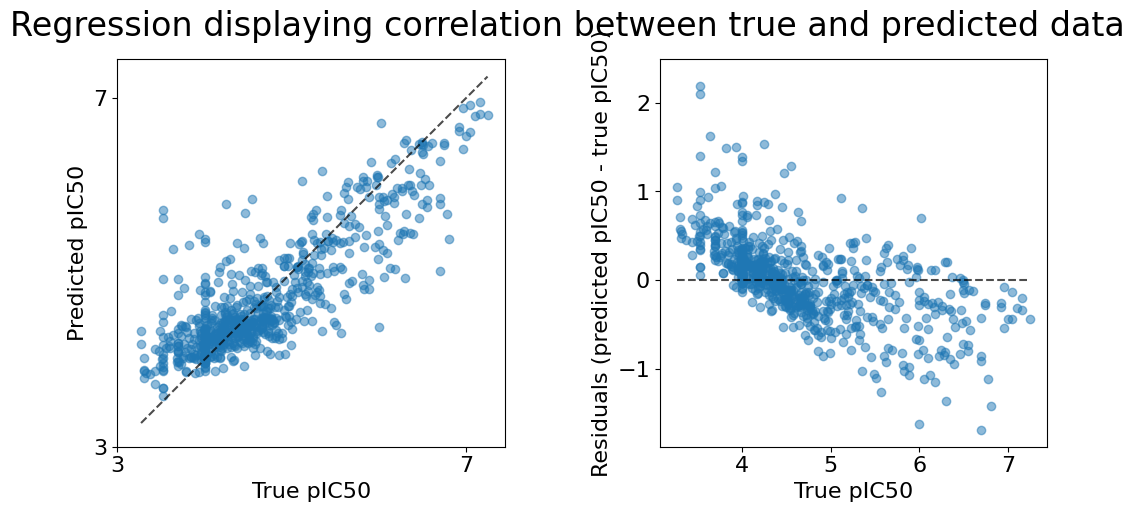

In [12]:
plot_cv_results(y_data_morgan, y_predictions_morgan, log=True)

#### On HeLa, Morgan fingerprints

In [17]:
metals_morgan_hela = metals_morgan[metals_morgan['Cells'] == 'HeLa']
metals_morgan_hela.reset_index(drop=True, inplace=True)

X_hela = np.array(metals_morgan_hela['Fingerprint'].values.tolist())
y_hela = np.array(metals_morgan_hela['pIC50'].values.tolist())

indices_morgan_hela = get_indices(metals_morgan_hela, CV=10, shuffle=True)

train length : 164 | test length : 19
train length : 164 | test length : 19
train length : 164 | test length : 19
train length : 165 | test length : 18
train length : 165 | test length : 18
train length : 165 | test length : 18
train length : 165 | test length : 18
train length : 165 | test length : 18
train length : 165 | test length : 18
train length : 165 | test length : 18


In [14]:
y_data_morgan_hela, y_predictions_morgan_hela = cross_validation(metals_morgan_hela, indices_morgan_hela, X_hela, y_hela, rf_morgan)

CV iteration 0
CV iteration 1
CV iteration 2
CV iteration 3
CV iteration 4
CV iteration 5
CV iteration 6
CV iteration 7
CV iteration 8
CV iteration 9
{'MAE': 0.27265206906106726, 'RMSE': 0.386809415448925, 'Ratio': 1.4186923898321466, 'R² Score': 0.5240584842968812}


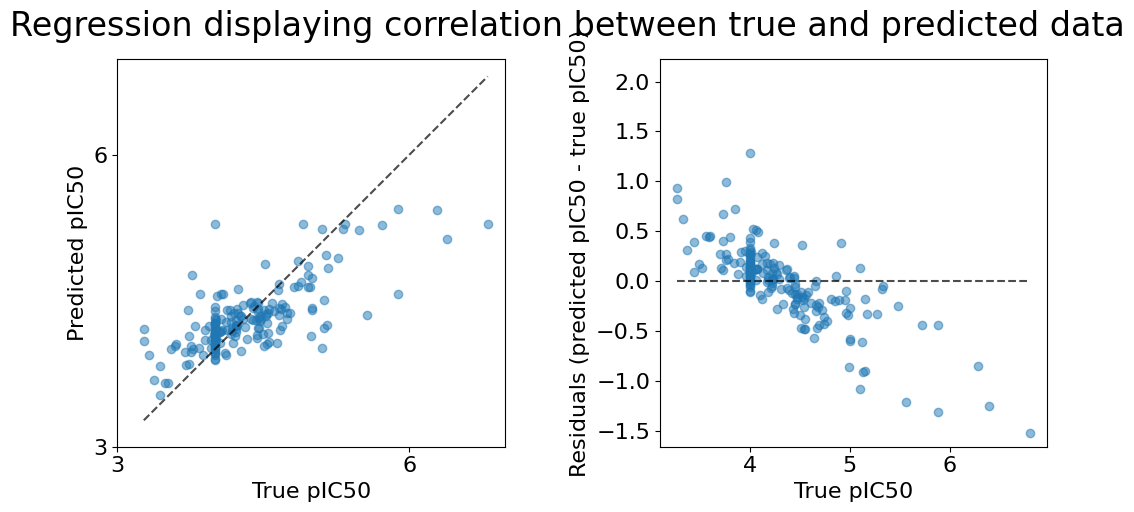

In [15]:
plot_cv_results(y_data_morgan_hela, y_predictions_morgan_hela, log=True)

## DOI Splitting


#### On the whole dataset, Morgan fingerprint

In [19]:
metals_morgan_doi = metals_morgan.copy()
metals_morgan_doi.reset_index(drop=True, inplace=True)

X_morgan_doi = np.array(metals_morgan_doi['Fingerprint'].values.tolist())
y_morgan_doi = np.array(metals_morgan_doi['pIC50'].values.tolist())

indices_morgan_doi = get_indices_doi(metals_morgan_doi, CV=10)

fold 0 groups: train 200 test 20
fold 0 train set : 646 | test set : 72
fold 1 groups: train 198 test 22
fold 1 train set : 646 | test set : 72
fold 2 groups: train 198 test 22
fold 2 train set : 646 | test set : 72
fold 3 groups: train 198 test 22
fold 3 train set : 646 | test set : 72
fold 4 groups: train 198 test 22
fold 4 train set : 646 | test set : 72
fold 5 groups: train 198 test 22
fold 5 train set : 646 | test set : 72
fold 6 groups: train 197 test 23
fold 6 train set : 646 | test set : 72
fold 7 groups: train 197 test 23
fold 7 train set : 646 | test set : 72
fold 8 groups: train 198 test 22
fold 8 train set : 647 | test set : 71
fold 9 groups: train 198 test 22
fold 9 train set : 647 | test set : 71


In [20]:
y_data_morgan_doi, y_predictions_morgan_doi = cross_validation(metals_morgan_doi, indices_morgan_doi, X_morgan_doi, y_morgan_doi, rf_morgan)

CV iteration 0
CV iteration 1
CV iteration 2
CV iteration 3
CV iteration 4
CV iteration 5
CV iteration 6
CV iteration 7
CV iteration 8
CV iteration 9
{'MAE': 0.5195556016002596, 'RMSE': 0.736914007726285, 'Ratio': 1.4183544657329257, 'R² Score': 0.2193942079622615}


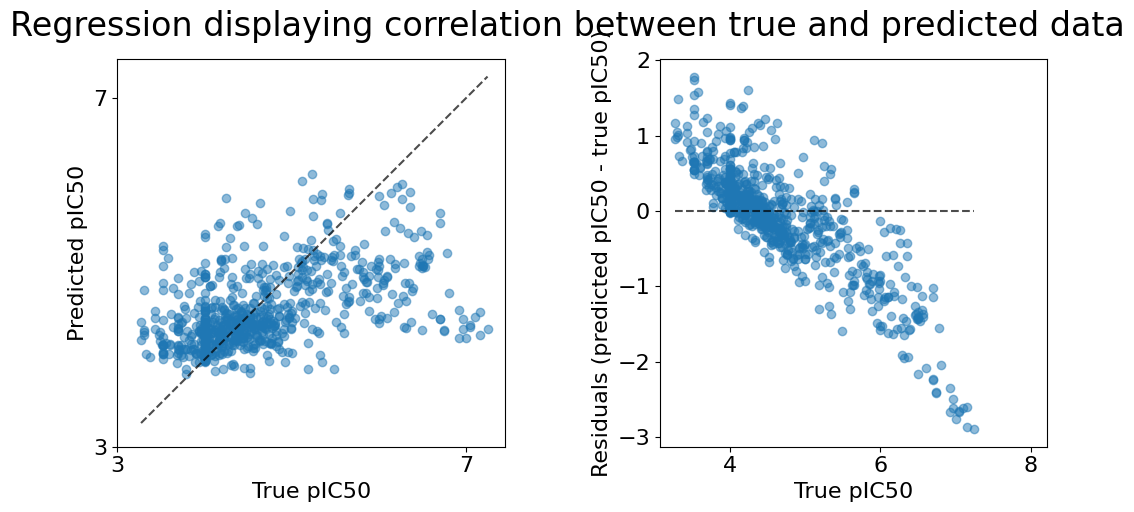

In [21]:
plot_cv_results(y_data_morgan_doi, y_predictions_morgan_doi, log=True)

## Scaffold Splitting

#### Scaffold for ligand A, Morgan Fingerprint

In [27]:
metals_A = metals_morgan.copy()
metals_A.reset_index(drop=True, inplace=True)

X_A = np.array(metals_A['Fingerprint'].values.tolist())
y_A = np.array(metals_A['pIC50'].values.tolist())

# We must extract the mol objects as the get_indices_scaff take a list of mol objects as argument, not a dataframe
molsA = metals_A['MOL1'].tolist()

indicesA = get_indices_scaff(molsA, CV=10)

100%|██████████████████████████████████████████████████████████████████████████████| 718/718 [00:00<00:00, 6508.36it/s]

train length : 651 | test length : 67
train length : 689 | test length : 29
train length : 684 | test length : 34
train length : 701 | test length : 17
train length : 706 | test length : 12
train length : 712 | test length : 6
train length : 507 | test length : 211
train length : 705 | test length : 13
train length : 709 | test length : 9
train length : 398 | test length : 320


In [25]:
y_dataA, y_predictionsA = cross_validation(metals_A, indicesA, X_A, y_A, rf_morgan)

CV iteration 0
CV iteration 1
CV iteration 2
CV iteration 3
CV iteration 4
CV iteration 5
CV iteration 6
CV iteration 7
CV iteration 8
CV iteration 9
{'MAE': 0.5179238073958194, 'RMSE': 0.7445787648224121, 'Ratio': 1.4376222027063015, 'R² Score': 0.20307135461213988}


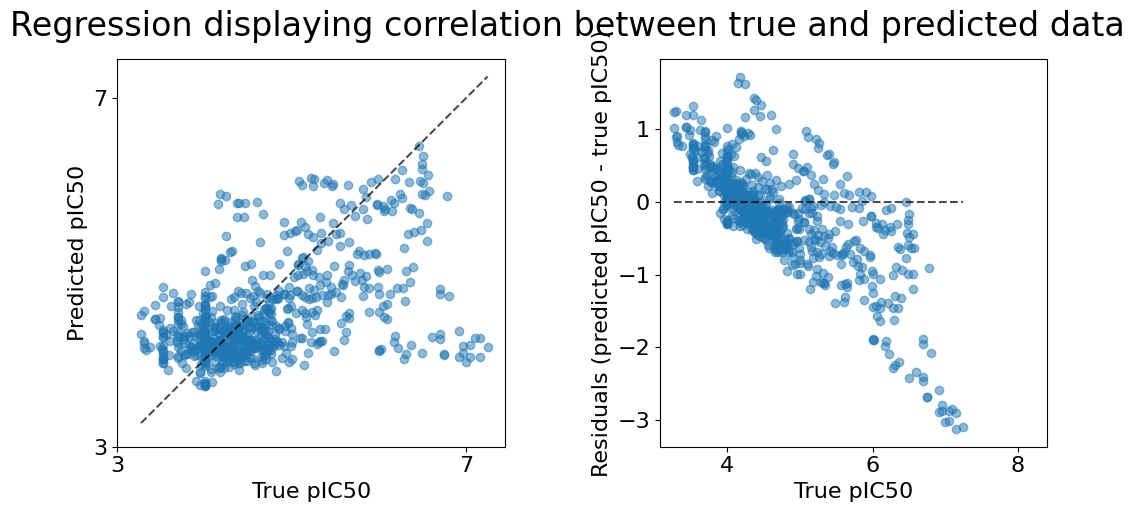

In [26]:
plot_cv_results(y_dataA, y_predictionsA, log=True)

#### Scaffold for ligand B, Morgan Fingerprint

In [29]:
metals_B = metals_morgan.copy()
metals_B.reset_index(drop=True, inplace=True)

X_B = np.array(metals_B['Fingerprint'].values.tolist())
y_B = np.array(metals_B['pIC50'].values.tolist())

# We must extract the mol objects as the get_indices_scaff take a list of mol objects as argument, not a dataframe
molsB = metals_B['MOL3'].tolist()

indicesB = get_indices_scaff(molsB, CV=10)

100%|██████████████████████████████████████████████████████████████████████████████| 718/718 [00:00<00:00, 1977.21it/s]

train length : 676 | test length : 42
train length : 577 | test length : 141
train length : 672 | test length : 46
train length : 594 | test length : 124
train length : 673 | test length : 45
train length : 677 | test length : 41
train length : 601 | test length : 117
train length : 647 | test length : 71
train length : 674 | test length : 44
train length : 671 | test length : 47


In [30]:
y_dataB, y_predictionsB = cross_validation(metals_B, indicesB, X_B, y_B, rf_morgan)

CV iteration 0
CV iteration 1
CV iteration 2
CV iteration 3
CV iteration 4
CV iteration 5
CV iteration 6
CV iteration 7
CV iteration 8
CV iteration 9
{'MAE': 0.46698535805604996, 'RMSE': 0.6542607973390129, 'Ratio': 1.401030644863356, 'R² Score': 0.38468154250647113}


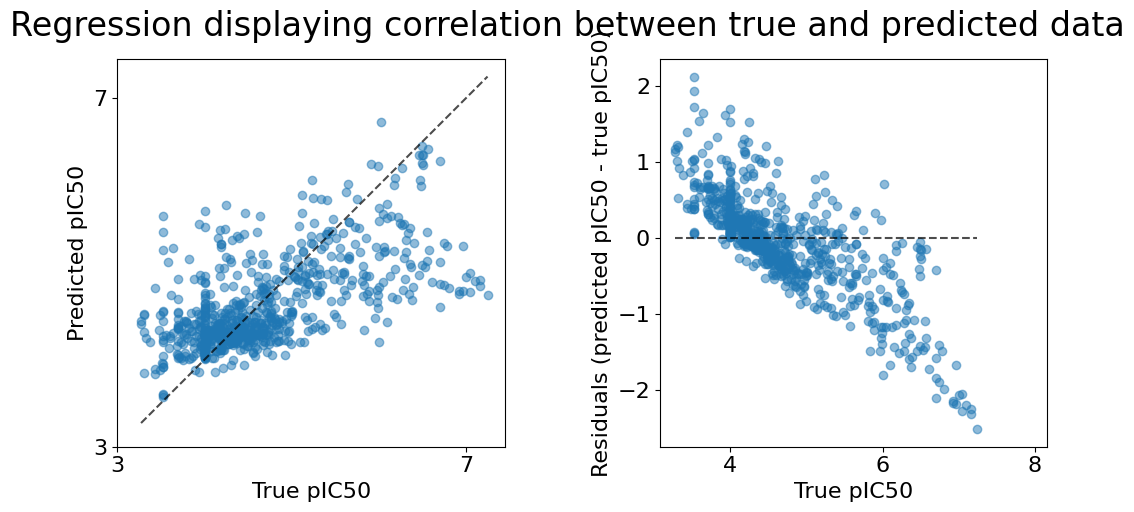

In [31]:
plot_cv_results(y_dataB, y_predictionsB, log=True)